### Student Information
Name: Keith Saudjana

Student ID: 113062421

GitHub ID: Keith-Saudjana

Kaggle name:

Kaggle private scoreboard snapshot:

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

### 0. Initialization

In [3]:
# import library
import os
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import umap
import gensim
import tensorflow
import keras
import json
import string
from tqdm import tqdm
import concurrent.futures
import multiprocessing

%matplotlib inline

print("gensim: " + gensim.__version__)
print("tensorflow: " + tensorflow.__version__)
print("keras: " + keras.__version__)

gensim: 4.3.3
tensorflow: 2.12.0
keras: 2.12.0


In [4]:
# setup cuda for GPU usage
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device name: {torch.cuda.get_device_name(device)}")

Device name: NVIDIA GeForce GTX 1660 Ti


### 1. Data Loading

#### Load Data

In [ ]:
# get tweets and respective ids
tweets = pd.read_json(r'data/tweets_DM.json', lines=True)

tweets = pd.json_normalize(tweets['_source'])[['tweet.tweet_id', 'tweet.text']]

tweets = tweets.rename(columns={'tweet.tweet_id': 'tweet_id', 'tweet.text': 'text'})

In [26]:
tweets

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [ ]:
# get emotion values
emotion = pd.read_csv(r'data/emotion.csv')

In [28]:
emotion

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [ ]:
# get data identification
data_identification = pd.read_csv(r'data/data_identification.csv')

In [30]:
data_identification

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [ ]:
# combine data to singular data frame
main_df = tweets.merge(emotion, on="tweet_id", how="left").merge(data_identification, on="tweet_id", how="left")

main_df

,tweet_id,text,emotion,identification
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation,train
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness,train
2,0x28b412,"Confident of your obedience, I write to you, k...",NaN,test
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,train
4,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN,test
...,...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN,test
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN,test
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,NaN,test
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",joy,train


In [ ]:
# extract training data
train_val_df = main_df[main_df['identification'] == 'train'].drop('identification', axis=1, inplace=False)
train_val_df.drop('tweet_id', axis=1, inplace=True)

train_val_df

,text,emotion
0,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,"@brianklaas As we see, Trump is dangerous to #...",sadness
3,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
5,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
6,Still waiting on those supplies Liscus. <LH>,anticipation
...,...,...
1867526,I'm SO HAPPY!!! #NoWonder the name of this sho...,joy
1867527,In every circumtance I'd like to be thankful t...,joy
1867528,there's currently two girls walking around the...,joy
1867533,"Ah, corporate life, where you can date <LH> us...",joy


In [ ]:
# extract testing data
test_df = main_df[main_df['identification'] == 'test'].drop('identification', axis=1, inplace=False)

test_df

,tweet_id,text,emotion
2,0x28b412,"Confident of your obedience, I write to you, k...",NaN
4,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN
9,0x218443,When do you have enough ? When are you satisfi...,NaN
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",NaN
33,0x26289a,"In these tough times, who do YOU turn to as yo...",NaN
...,...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from th...",NaN
1867529,0x2a980e,"""There is a lad here, which hath five barley l...",NaN
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN


#### 1.2 Save and Load Data

In [ ]:
# reset index to save to pickle
train_val_df = train_val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
# save dataframe
train_val_df.to_pickle("pkl/train_val_df.pkl") 
test_df.to_pickle("pkl/test_df.pkl")

In [55]:
# load dataframe
train_val_df = pd.read_pickle("pkl/train_val_df.pkl")
test_df = pd.read_pickle("pkl/test_df.pkl")

#### 1.3 Exploratory data analysis (EDA)

In [ ]:
# count number of each sentiment
train_val_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

In [15]:
# visualize sentiment amounts
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def visualize_sentiment_distribution(df, figsize=(5, 3)):
    # Get unique emotions
    labels = df['emotion'].unique()
    post_total = len(df)
    
    # calculate percentage distribution
    df1 = df.groupby(['emotion']).count()['text']
    df1 = df1.apply(lambda x: round(x * 100 / post_total, 3))
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    plt.bar(df1.index, df1.values, color='skyblue', edgecolor='black')
    
    plt.ylabel('% of Instances')
    plt.xlabel('Emotion')
    plt.title('Emotion Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)
    
    # Show plot
    plt.show()

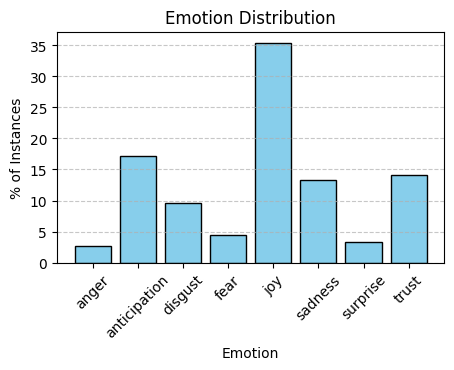

In [16]:
visualize_sentiment_distribution(train_val_df)

### 2. Preprocessing

#### Text Preprocessing

In [56]:
# import and download preprocessing functions and their requirements
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 

# setup stopwords
stopWords = set(stopwords.words('english'))
stopWords.add('lh')

# setup lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [57]:
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px


def show_top_100_terms(text):
    count_vect = CountVectorizer()

    # tokenize text
    train_counts = count_vect.fit_transform(text)
    
    # transform count to frequency array
    term_frequencies = np.asarray(train_counts.sum(axis=0)).flatten()

    # find top 100 terms
    top_100_indices = term_frequencies.argsort()[-100:][::-1]

    top_100_terms = count_vect.get_feature_names_out()[top_100_indices]
    top_100_terms_freq = term_frequencies[top_100_indices]

    print(top_100_terms.tolist())
    print(top_100_terms_freq.tolist())

    top_100_freq_data = pd.DataFrame({
        'term': top_100_terms,
        'freq': top_100_terms_freq
    })

    # bar plot visualization
    fig = px.bar(top_100_freq_data, x='term', y='freq', title='Top 100 Term Frequencies',
                 text='freq', color_discrete_sequence=['red'])

    fig.update_layout(
        xaxis_title='Terms',
        yaxis_title='Frequencies',
        width=1000,
        height=500
    )

    fig.show()

In [58]:
# preprocessing of a single text
def process_single_text(text):
    # convert all words to lower case
    tokens = word_tokenize(text.lower())

    # remove all stop words and not alphabetical values
    tokens = [token for token in tokens if token.isalpha() and token not in stopWords]

    # lemmatize other words
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [59]:
# old preprocess code
def preprocess_text(texts):
    if isinstance(texts, pd.Series):
        return texts.apply(process_single_text).tolist()
    elif isinstance(texts, list):
        return list(map(process_single_text, texts))
    elif isinstance(texts, str):
        return [process_single_text(texts)]
    

In [60]:
# utilize multithreading to optimize preprocessing of list of texts
def preprocess_text_optimized(texts):
    if isinstance(texts, str):
        texts = pd.Series([texts])
    with concurrent.futures.ThreadPoolExecutor() as executor:
        processed_texts = list(executor.map(process_single_text, texts))
    
    return processed_texts


In [61]:
preprocess_train_val_df = train_val_df.copy()
preprocess_test_df = test_df.copy()

In [62]:
# create new feature for preprocessed texts
preprocess_train_val_df['preprocessed'] = preprocess_text_optimized(preprocess_train_val_df['text'])

In [63]:
preprocess_train_val_df

,text,emotion,preprocessed
0,"People who post ""add me on #Snapchat"" must be ...",anticipation,people post add snapchat must dehydrated cuz man
1,"@brianklaas As we see, Trump is dangerous to #...",sadness,brianklaas see trump dangerous freepress aroun...
2,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,issa stalking tasha
3,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy,riskshow thekevinallison thx best time tonight...
4,Still waiting on those supplies Liscus. <LH>,anticipation,still waiting supply liscus
...,...,...,...
1455558,I'm SO HAPPY!!! #NoWonder the name of this sho...,joy,happy nowonder name show happy happysyfy syfy
1455559,In every circumtance I'd like to be thankful t...,joy,every circumtance like thankful almighty jesus...
1455560,there's currently two girls walking around the...,joy,currently two girl walking around library hand...
1455561,"Ah, corporate life, where you can date <LH> us...",joy,ah corporate life date using relative anachron...


In [64]:
# create new feature for preprocessed texts
preprocess_test_df['preprocessed'] = preprocess_text_optimized(preprocess_test_df['text'])

In [65]:
preprocess_test_df

,tweet_id,text,emotion,preprocessed
0,0x28b412,"Confident of your obedience, I write to you, k...",NaN,confident obedience write knowing even ask phi...
1,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN,trust faith friend someone trust putting faith...
2,0x218443,When do you have enough ? When are you satisfi...,NaN,enough satisfied goal really money materialism...
3,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",NaN,god woke chase day godsplan godswork
4,0x26289a,"In these tough times, who do YOU turn to as yo...",NaN,tough time turn symbol hope
...,...,...,...,...
411967,0x2913b4,"""For this is the message that ye heard from th...",NaN,message ye heard beginning love one another jo...
411968,0x2a980e,"""There is a lad here, which hath five barley l...",NaN,lad hath five barley loaf two small fish among...
411969,0x316b80,When you buy the last 2 tickets remaining for ...,NaN,buy last ticket remaining show sell mixedfeeli...
411970,0x29d0cb,I swear all this hard work gone pay off one da...,NaN,swear hard work gone pay one


In [66]:
# save new data frames
preprocess_train_val_df.to_pickle("pkl/preprocess_train_val_df.pkl") 
preprocess_test_df.to_pickle("pkl/preprocess_test_df.pkl") 

In [67]:
# load new data frames
preprocess_train_val_df = pd.read_pickle("pkl/preprocess_train_val_df.pkl")
preprocess_test_df = pd.read_pickle("pkl/preprocess_test_df.pkl")

In [68]:
show_top_100_terms(preprocess_train_val_df['preprocessed'])

['love', 'life', 'day', 'today', 'like', 'god', 'get', 'one', 'time', 'good', 'people', 'make', 'know', 'got', 'go', 'see', 'never', 'thank', 'pip', 'thing', 'new', 'need', 'come', 'work', 'want', 'great', 'happy', 'realdonaldtrump', 'much', 'back', 'ca', 'still', 'say', 'year', 'thanks', 'lot', 'going', 'always', 'give', 'let', 'would', 'way', 'really', 'best', 'feel', 'week', 'dream', 'right', 'world', 'think', 'even', 'please', 'last', 'first', 'friend', 'look', 'hope', 'moment', 'another', 'man', 'night', 'take', 'total', 'morning', 'ever', 'keep', 'every', 'closed', 'follow', 'someone', 'better', 'feeling', 'show', 'blessed', 'eurusd', 'amazing', 'could', 'well', 'help', 'tonight', 'play', 'guy', 'everyone', 'sad', 'family', 'made', 'believe', 'everything', 'many', 'na', 'home', 'jesus', 'game', 'wait', 'girl', 'nothing', 'watching', 'next', 'trump', 'done']
[88998, 83371, 74671, 68650, 59795, 59485, 54922, 53163, 49846, 47004, 44745, 42816, 38642, 36943, 33679, 33389, 33191, 3311

### 3. Model

#### Notes
**Things to try:**
- Feature engineering (Word2Vec, PCA, LDA, FastText, Clustering)
- Fix dataset skew

**Models:**
- BERT (Transformer): 110 million parameters
- DistilBERT (Transformer): 66 million parameters
- MiniLM (Trannsformer): 15 million or 33 million parameters



In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [70]:
# prepare data for train and validation split
# texts = preprocess_train_val_df['text'].values
texts = preprocess_train_val_df['preprocessed'].values
labels = preprocess_train_val_df['emotion'].values

# convert emotion values to categorical integers
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [71]:
# create emotion dictionary for easy conversion
label_mapping = {original: encoded for original, encoded in zip(encoder.classes_, range(len(encoder.classes_)))}

label_mapping

{'anger': 0,
 'anticipation': 1,
 'disgust': 2,
 'fear': 3,
 'joy': 4,
 'sadness': 5,
 'surprise': 6,
 'trust': 7}

In [72]:
# create reverse emotion dictionary for easy conversion
reverse_mapping = {encoded: original for original, encoded in label_mapping.items()}

reverse_mapping

{0: 'anger',
 1: 'anticipation',
 2: 'disgust',
 3: 'fear',
 4: 'joy',
 5: 'sadness',
 6: 'surprise',
 7: 'trust'}

In [73]:
# split training data to training and validation
X_train, X_val, y_train, y_val = train_test_split(texts, encoded_labels, stratify = encoded_labels)

In [74]:
# prepare test data
X_test = preprocess_test_df['preprocessed'].values

#### LSTM

In [75]:
import re
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

In [76]:
# variable for data preparation
vocab_size = 3000
oov_tok = ''
embedding_dim = 100
max_length = 200
num_classes = 8

##### Setup

In [77]:
# initialize tokenizaer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# fit tokenizer on training data to build word index
tokenizer.fit_on_texts(X_train)

# retreive word index
word_index = tokenizer.word_index

# Convert data into sequences of integers 
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the data sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
val_padded = pad_sequences(val_sequences, padding='post', maxlen=max_length)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [79]:
# Define model architecture
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Define learning rate and decay
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Create Adam optimizer with learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# compile model with loss function, optimizer, and metrics
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# show model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          300000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                3096      
                                                                 
 dense_5 (Dense)             (None, 8)                 200       
                                                                 
Total params: 387,776
Trainable params: 387,776
Non-trainable params: 0
_________________________________________________________________


##### Training and Validation

In [80]:
# train and validate model
num_epochs = 5
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=1, 
                    validation_data=(val_padded, y_val))

Epoch 1/5
34115/34115 [==============================] - 3656s 107ms/step - loss: 1.3593 - accuracy: 0.5102 - val_loss: 1.3202 - val_accuracy: 0.5234
Epoch 2/5
34115/34115 [==============================] - 3512s 103ms/step - loss: 1.3013 - accuracy: 0.5301 - val_loss: 1.3058 - val_accuracy: 0.5283
Epoch 3/5
34115/34115 [==============================] - 3465s 102ms/step - loss: 1.2774 - accuracy: 0.5388 - val_loss: 1.3001 - val_accuracy: 0.5311
Epoch 4/5
34115/34115 [==============================] - 3468s 102ms/step - loss: 1.2585 - accuracy: 0.5458 - val_loss: 1.3003 - val_accuracy: 0.5308
Epoch 5/5
34115/34115 [==============================] - 3471s 102ms/step - loss: 1.2419 - accuracy: 0.5518 - val_loss: 1.3022 - val_accuracy: 0.5304


In [81]:
# save model
model.save(r'lstm_model.keras')

##### Inference

In [54]:
from tensorflow.keras.models import load_model

# load model
loaded_model = load_model(r'checkpoints\LSTM\lstm_model_preprocessed.keras')

# predict test data
prediction = loaded_model.predict(test_padded)

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 200], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [49]:
# convert logits to emotion values
def convert_logits(logits_list):
    predictions = []
    
    for logits in logits_list:
        # find highest value logit
        logits = np.array(logits)
        max_index = np.argmax(logits)
        
        # convert highest value logit to emotion value
        predictions.append(reverse_mapping[max_index])
    
    return predictions

In [50]:
# create dataframe for submission
answer_df = pd.DataFrame()

answer_df['id'] = test_df['tweet_id']
answer_df['emotion'] = convert_logits(prediction)

In [51]:
answer_df

,id,emotion
0,0x28b412,trust
1,0x2de201,anticipation
2,0x218443,disgust
3,0x2939d5,trust
4,0x26289a,trust
...,...,...
411967,0x2913b4,anticipation
411968,0x2a980e,surprise
411969,0x316b80,anger
411970,0x29d0cb,anger


In [52]:
# save as csv file
answer_df.to_csv('submission.csv', index=False)

#### Transformer (Unused - Takes too long to run)

In [12]:
from transformers import AdamW, BertForSequenceClassification, BertTokenizer, get_scheduler
from sentence_transformers import SentenceTransformer, InputExample, LoggingHandler
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
import torch.nn as nn
import torch

print("torch: " + torch.__version__)


torch: 2.5.1+cu118


In [13]:
num_labels = 8
max_length = 64
batch_size = 16
num_epochs = 3
learning_rate = 2e-5
weight_decay = 0.01

##### Setup

In [14]:
tokenizer = BertTokenizer.from_pretrained('microsoft/MiniLM-L12-H384-uncased')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--microsoft--MiniLM-L12-H384-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [15]:
model_name = 'microsoft/MiniLM-L12-H384-uncased'

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e

In [16]:
def get_dataloader(texts, labels=None, max_seq_len=max_length, batch_size=batch_size, shuffle=True):
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()

    encoded_inputs = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    token_type_ids = encoded_inputs.get('token_type_ids', torch.zeros_like(input_ids))
    
    if labels is not None:
        if isinstance(labels, pd.Series):
            labels = labels.tolist()
        label_ids = torch.tensor(labels, dtype=torch.long)

        dataset = TensorDataset(input_ids, attention_mask, token_type_ids, label_ids)
    else:
        dataset = TensorDataset(input_ids, attention_mask, token_type_ids)

    return DataLoader(dataset, shuffle=shuffle, batch_size=batch_size)

In [17]:
train_dataloader = get_dataloader(X_train, y_train)
val_dataloader = get_dataloader(X_val, y_val)

In [18]:
test_dataloader = get_dataloader(X_test)

##### Training and Validation

In [19]:
# Evaluation Function
def evaluate(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels = []
    correct_labels = []

    for step in enumerate(tqdm(dataloader, desc = 'Evaluation iteration')):
        batch = tuple (t.to(device) for t in batch)
        input_ids, input_mask, token_type_id, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask, token_type_id=token_type_id, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()

        predicted_labels += list(outputs)
        correct_labels += list(label_ids)

        eval_loss += tmp_eval_loss.mean().time()
        nb_eval_steps += 1

    eval_loss = eval_loss/nb_eval_steps

    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)

    return eval_loss, correct_labels, predicted_labels

In [20]:
GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / batch_size / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)


c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
import os
from tqdm import trange, tqdm
# from tqdm.notebook import tqdm as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "checkpoints\BERT"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    test_loss, _, _ = evaluate(model, test_dataloader)
    
    print("Loss history:", loss_history)
    print("test loss:", test_loss)
    
    if len(loss_history) == 0 or test_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(test_loss)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

##### Inference

In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(model_name, state_dict=model_state_dict, num_labels = len(label_mapping))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, val_correct, val_predicted = evaluate(model, val_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(val_correct, val_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted, target_names=label_mapping))

### 4. Report

**Preprocessing**  
The text preprocessing process of the model utilizes transformation, removal of stop words (and non alphabetical values), and lemmatization:
- transformation is done by converting all words to their lower case form.
- stop words are taken from nltk's list of stop words. Other words are added that just seem odd to be included such as lh, which appears in the top 100 terms for some reason.
- non alphabetical values are also removed as they do not add much value to sentiment (except perhaps punctuation).
- lemmatization is performed in order to minimize word variety.

**Feature Creation**  
Throughout the entire model, only one feature was created which is the preprocessed texts feature which is used as the input for the training, validation, and testing instead of the usual text.

**Model**  
The model used is the LSTM model due to its simplicity and because they are designed to capture sequential dependencies in data such as text. Sentiment usually depends on the context provided by the sequence of words and LSTM is designed to 'remember' earlier words in the sequence which helps to determine the sentiment.

The model is fed the preprocessed texts from the feature creation step. It will also be tested by preprocessed test data. Due to the sheer size of the dataset, training is only conducted for 5 epochs which already shows promising results (~42%).

Initially a BERT model was meant to be used but due to computational limitations, it is scrapped. The code for the BERT model is provided but no comments are given.

**Result Analysis**  
- Baseline Model (only LSTM): ~43%  
- LSTM + Preprocessing:   
- LSTM + Data Balancing + Preprocessing: ~32%